In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import SGD ,AdamW

from datasets import load_dataset, load_metric

import matplotlib.pyplot as plt

import json
from statistics import mean

In [2]:
import utils_generic as generic
import multitask_dep as mt
import model_confs as confs
import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tasks = ['to','as','about']

In [4]:
model_conf = confs.roberta_conf
encoding_type = 'pos'

# Datos ConvAI

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = mt.Vocabulary(data['train'],encoding_type)

convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [7]:
convai_train_dataset = mt.DatasetMultitaskDep(convai_train_token,tasks,eval=False)
convai_val_dataset = mt.DatasetMultitaskDep(convai_val_token,tasks,eval=False)

# Datos md_gender

In [8]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [9]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 
md_dataset = mt.DatasetMultitaskDep(md_tokenized,tasks,eval=True)

# Creación dataloaders

In [10]:
dl_train =DataLoader(convai_train_dataset,batch_size=128,shuffle=True,collate_fn=mt.collate_fn)
dl_val =DataLoader(convai_val_dataset,batch_size=128,shuffle=True,collate_fn=mt.collate_fn)
dl_eval = DataLoader(md_dataset,batch_size=128,shuffle=False,collate_fn=mt.collate_fn)

# Modelo multitask

In [11]:
num_epochs = 100
learning_rate = 1e-6

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.056532934152291 	 Validation loss: 1.9957204450995236 	 
  1%|          | 574/57400 [01:41<2:31:08,  6.27it/s]
Epoch 2 	 Training loss: 1.9950191638195556 	 Validation loss: 1.9788553755162126 	 
  2%|▏         | 1148/57400 [03:24<2:33:12,  6.12it/s]
Epoch 3 	 Training loss: 1.9858330770652053 	 Validation loss: 1.9733183000047327 	 
  3%|▎         | 1722/57400 [05:05<2:41:12,  5.76it/s]
Epoch 4 	 Training loss: 1.9821403153266641 	 Validation loss: 1.9743073895826178 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [06:47<2:32:17,  6.03it/s]
Epoch 5 	 Training loss: 1.9761684848456433 	 Validation loss: 1.972072524539495 	 
  5%|▌         | 2870/57400 [08:30<2:27:48,  6.15it/s]
Epoch 6 	 Training loss: 1.9714031192483803 	 Validation loss: 1.9615627587851832 	 
  6%|▌         | 3444/57400 [10:10<2:26:17,  6.15it/s]
Epoch 7 	 Training loss: 1.9694765818659021 	 Validation loss: 1.9655938087883642 	 

1 epoch without improvement
  7%|▋         | 401

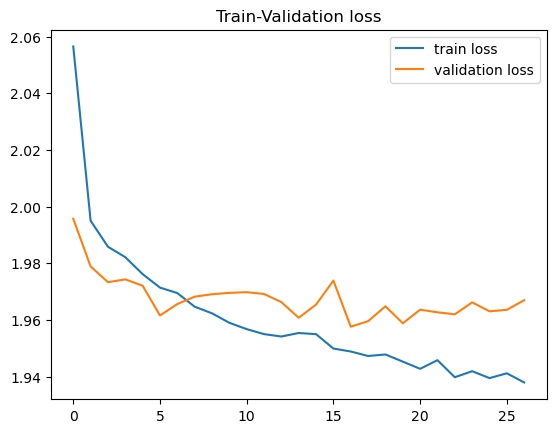

In [12]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
save_path='roberta_multitask_pos_1'
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [13]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación del modelo
{'to': {'recall': 0.7121212121212122, 'precision': 0.7121212121212122, 'f1': 0.7121212121212122, 'accuracy': 0.7121212121212122}, 'as': {'recall': 0.7314211212516297, 'precision': 0.7314211212516297, 'f1': 0.7314211212516297, 'accuracy': 0.7314211212516297}, 'about': {'recall': 0.8405612244897959, 'precision': 0.8405612244897959, 'f1': 0.8405612244897959, 'accuracy': 0.8405612244897959}} 

Evaluación en etiquetas male
{'to': {'recall': 0.7177615571776156, 'precision': 0.7177615571776156, 'f1': 0.7177615571776156, 'accuracy': 0.7177615571776156}, 'as': {'recall': 0.7272727272727273, 'precision': 0.7272727272727273, 'f1': 0.7272727272727273, 'accuracy': 0.7272727272727273}, 'about': {'recall': 0.8411458333333334, 'precision': 0.8411458333333334, 'f1': 0.8411458333333333, 'accuracy': 0.8411458333333334}} 

Evaluación en etiquetas female
{'to': {'recall': 0.7060367454068242, 'precision': 0.7060367454068242, 'f1': 0.7060367454068242, 'accuracy': 0.7060367454068242}, 'a

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0400553432906547 	 Validation loss: 2.0039500119322438 	 
  1%|          | 574/57400 [01:38<2:31:57,  6.23it/s]
Epoch 2 	 Training loss: 1.9908950895797917 	 Validation loss: 1.9784882614168071 	 
  2%|▏         | 1148/57400 [03:17<2:31:49,  6.17it/s]
Epoch 3 	 Training loss: 1.9831244891528883 	 Validation loss: 1.9726425954851055 	 
  3%|▎         | 1722/57400 [04:55<2:32:58,  6.07it/s]
Epoch 4 	 Training loss: 1.9744990584326954 	 Validation loss: 1.9730078668917639 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [06:33<2:18:18,  6.64it/s]
Epoch 5 	 Training loss: 1.9723768792916674 	 Validation loss: 1.97462615320238 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [08:10<2:18:23,  6.57it/s]
Epoch 6 	 Training loss: 1.969285010460777 	 Validation loss: 1.973778989355443 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [09:49<2:12:21,  6.79it/s]
Epoch 7 	 Training loss: 1.966930007269989 	 Validation loss: 1.97426101918947

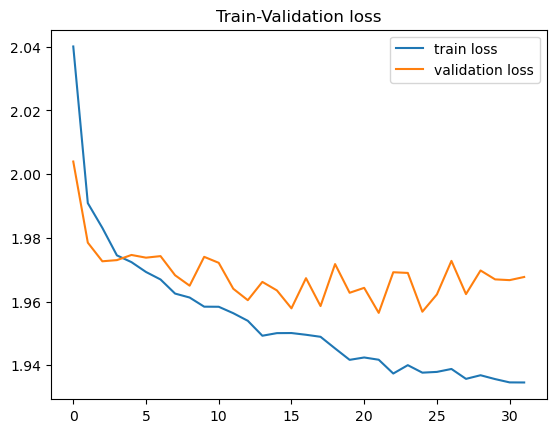

In [14]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
save_path='roberta_multitask_pos_2'
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [15]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación del modelo
{'to': {'recall': 0.7108585858585859, 'precision': 0.7108585858585859, 'f1': 0.7108585858585859, 'accuracy': 0.7108585858585859}, 'as': {'recall': 0.727509778357236, 'precision': 0.727509778357236, 'f1': 0.727509778357236, 'accuracy': 0.727509778357236}, 'about': {'recall': 0.8418367346938775, 'precision': 0.8418367346938775, 'f1': 0.8418367346938774, 'accuracy': 0.8418367346938775}} 

Evaluación en etiquetas male
{'to': {'recall': 0.7347931873479319, 'precision': 0.7347931873479319, 'f1': 0.7347931873479319, 'accuracy': 0.7347931873479319}, 'as': {'recall': 0.7424242424242424, 'precision': 0.7424242424242424, 'f1': 0.7424242424242424, 'accuracy': 0.7424242424242424}, 'about': {'recall': 0.8541666666666666, 'precision': 0.8541666666666666, 'f1': 0.8541666666666666, 'accuracy': 0.8541666666666666}} 

Evaluación en etiquetas female
{'to': {'recall': 0.6850393700787402, 'precision': 0.6850393700787402, 'f1': 0.6850393700787402, 'accuracy': 0.6850393700787402}, 'as': 

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0496950731044863 	 Validation loss: 1.998800120111239 	 
  1%|          | 574/57400 [01:37<2:27:32,  6.42it/s]
Epoch 2 	 Training loss: 1.9916617079063574 	 Validation loss: 1.984838675644438 	 
  2%|▏         | 1148/57400 [03:15<2:20:00,  6.70it/s]
Epoch 3 	 Training loss: 1.982284870920281 	 Validation loss: 1.9850552162881625 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [04:54<2:25:56,  6.36it/s]
Epoch 4 	 Training loss: 1.9764576699675582 	 Validation loss: 1.9737069505756184 	 
  4%|▍         | 2296/57400 [06:32<2:19:06,  6.60it/s]
Epoch 5 	 Training loss: 1.9721839135116817 	 Validation loss: 1.9739831403150396 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [08:09<2:33:01,  5.94it/s]
Epoch 6 	 Training loss: 1.9697019017531896 	 Validation loss: 1.9678740258944236 	 
  6%|▌         | 3444/57400 [09:46<2:15:53,  6.62it/s]
Epoch 7 	 Training loss: 1.9662760890734736 	 Validation loss: 1.9744354850154813 	 

1 epoch without impr

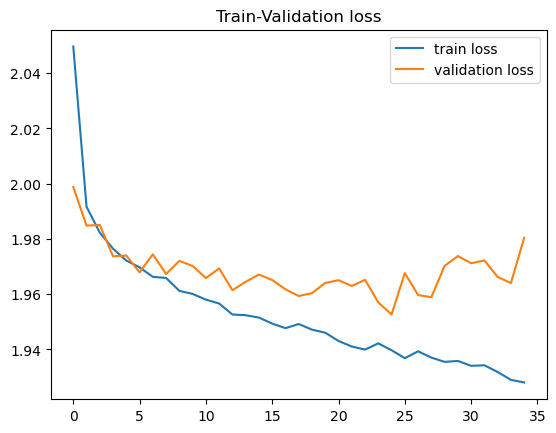

In [16]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
save_path='roberta_multitask_pos_3'
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [17]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación del modelo
{'to': {'recall': 0.7222222222222222, 'precision': 0.7222222222222222, 'f1': 0.7222222222222222, 'accuracy': 0.7222222222222222}, 'as': {'recall': 0.7301173402868318, 'precision': 0.7301173402868318, 'f1': 0.7301173402868318, 'accuracy': 0.7301173402868318}, 'about': {'recall': 0.8469387755102041, 'precision': 0.8469387755102041, 'f1': 0.8469387755102041, 'accuracy': 0.8469387755102041}} 

Evaluación en etiquetas male
{'to': {'recall': 0.7372262773722628, 'precision': 0.7372262773722628, 'f1': 0.7372262773722628, 'accuracy': 0.7372262773722628}, 'as': {'recall': 0.7348484848484849, 'precision': 0.7348484848484849, 'f1': 0.7348484848484848, 'accuracy': 0.7348484848484849}, 'about': {'recall': 0.8515625, 'precision': 0.8515625, 'f1': 0.8515625, 'accuracy': 0.8515625}} 

Evaluación en etiquetas female
{'to': {'recall': 0.7060367454068242, 'precision': 0.7060367454068242, 'f1': 0.7060367454068242, 'accuracy': 0.7060367454068242}, 'as': {'recall': 0.7250673854447439, '

In [18]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.8431122448979592, 'precision': 0.8431122448979592, 'f1': 0.8431122448979591, 'accuracy': 0.8431122448979592}
Métricas etiqueta male: {'recall': 0.8489583333333334, 'precision': 0.8489583333333334, 'f1': 0.8489583333333333, 'accuracy': 0.8489583333333334}
Métricas etiqueta female:  {'recall': 0.8375, 'precision': 0.8375, 'f1': 0.8374999999999999, 'accuracy': 0.8375}

 to
Resultado global: {'recall': 0.7150673400673401, 'precision': 0.7150673400673401, 'f1': 0.7150673400673401, 'accuracy': 0.7150673400673401}
Métricas etiqueta male: {'recall': 0.7299270072992701, 'precision': 0.7299270072992701, 'f1': 0.7299270072992701, 'accuracy': 0.7299270072992701}
Métricas etiqueta female:  {'recall': 0.6990376202974629, 'precision': 0.6990376202974629, 'f1': 0.6990376202974629, 'accuracy': 0.6990376202974629}

 as
Resultado global: {'recall': 0.7296827466318991, 'precision': 0.7296827466318991, 'f1': 0.7296827466318991, 'accuracy': 0.72968